# T1 Characterization

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        This tutorial demonstrate how can you use the framework to characterize T1 time of a single qubit system. Since we don't have real quantum device, we use our master equation solver to simulate the experiment.  
    </p>
</div>

In [ ]:
import jax
import jax.numpy as jnp
import inspeqtor as sq
from functools import partial

Let us define the our device for experimet. This device sample and estiamte a finite-shot expectation value given system parameters.

In [2]:
def shot_quantum_device(
    key: jnp.ndarray,
    param,
    initial_state: jnp.ndarray,
    observable: jnp.ndarray,
    shots: int,
    # Solver's static arguments
    hamiltonian,
    lindblad_ops ,
):
    # Solver is a function that return the final density matrix in this case
    # calculate the final density matrix
    t_eval = jnp.array([0., param[0]])
    dm = sq.physics.lindblad_solver(
        args=param,
        t_eval=t_eval,
        hamiltonian=hamiltonian,
        lindblad_ops=lindblad_ops,
        rho0=initial_state,
        t0=0.,
        t1=param[0],
    )[-1]
    # Calculate the expectation value
    # expval = jnp.real(jnp.trace(dm @ observable, axis1=1, axis2=2))
    # Sampling shot from expectation value
    return sq.experimental.utils.calculate_shots_expectation_value(
        key, dm, unitary=jnp.eye(2), operator=observable, shots=shots
    )

## Define the Control

Next, we define our control, this control is just to represent a amount of idle time before measurement. Thus, the envelope function do nothing and simply return zero

In [3]:
class ZeroControl(sq.experimental.control.BaseControl):
    total_dt = 100

    def get_bounds(
        self,
    ) -> tuple[sq.ctyping.ParametersDictType, sq.ctyping.ParametersDictType]:
        return {"t": 0.0}, {"t": total_dt}

    def get_envelope(self, params: sq.ctyping.ParametersDictType):
        def envelope(t):
            return jnp.array(0.0)

        return envelope


total_dt = 100  # Does not matter in the example
ctrl_seq = sq.control.ControlSequence(
    controls={"idle": ZeroControl(total_dt)}, total_dt=total_dt
)
ravel_fn, unravel_fn = sq.control.ravel_unravel_fn(ctrl_seq)

## Perform the Experiment

Below, we define our device and simulate the experiment.

In [21]:
key = jax.random.key(0)
initial_state = sq.experimental.data.State.from_label("1", dm=True)

# Lindblad operators for amplitude damping
T1 = 10
gamma = 1 / T1  # Decay rate
L_amp_damp = jnp.sqrt(gamma) * jnp.array([[0, 1], [0, 0]], dtype=jnp.complex64)

qubit_info = sq.experimental.predefined.get_mock_qubit_information()

signal_fn = sq.experimental.physics.signal_func_v5(
    sq.control.get_envelope_transformer(ctrl_seq),
    drive_frequency=qubit_info.frequency,
    dt=0.1,
)

sample_size = 51
shots = 1000
t_eval = jnp.linspace(0, total_dt, sample_size)

hamiltonian = partial(
    sq.experimental.predefined.rotating_transmon_hamiltonian,
    qubit_info=qubit_info,
    signal=signal_fn,
)

device = partial(
    shot_quantum_device,
    initial_state=initial_state,
    observable=sq.constant.Z,
    shots=shots,
    hamiltonian=hamiltonian,
    lindblad_ops=[L_amp_damp],
)

finite_shot_expvals = jax.vmap(device, in_axes=(None, 0))(key, t_eval.reshape(-1, 1))

/Users/porametpathumsoot/University/PhD/Projects/espresso/inspeqtor/.venv/lib/python3.13/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


The collected data can be visualized as follows. Notice that, since we collect the data as an expectation value $\langle 1 | \hat{O} | 1 \rangle$, we have to convert it to the probability of measuring excited state $|1\rangle$. 

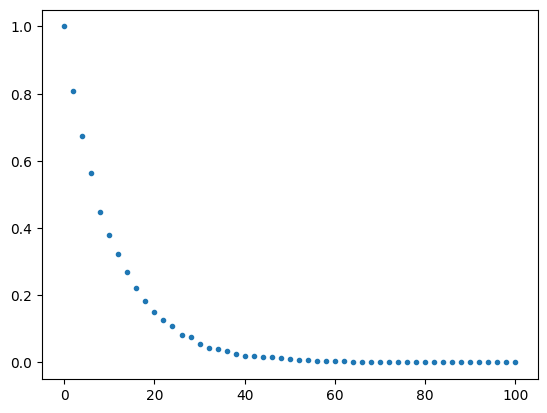

In [ ]:
import matplotlib.pyplot as plt
# Visualization
population = sq.experimental.utils.expectation_value_to_prob_minus(finite_shot_expvals)
plt.plot(t_eval, population, '.')

We can see the exponential decay from the experimental data.

## Save the Data

Next, let see how can we store the collected data using the tools from our framework.

In [23]:
import polars as pl
import numpy as np
from flax.traverse_util import flatten_dict

expectation_values = finite_shot_expvals.reshape(1, -1)
params_dict = jax.vmap(unravel_fn)(t_eval.reshape(-1, 1))
order = [sq.data.ExpectationValue("1", "Z")]
config = sq.data.ExperimentConfiguration(
    qubits=[qubit_info],
    expectation_values_order=order,
    parameter_structure=ctrl_seq.get_structure(),
    backend_name="simulator",
    shots=shots,
    EXPERIMENT_IDENTIFIER="0001",
    EXPERIMENT_TAGS=['decoherence', 'target characterization'],
    description="A target T1 experiment",
    device_cycle_time_ns=0.1,
    sequence_duration_dt=total_dt,
    instance="",
    sample_size=sample_size
)

param_df = pl.DataFrame(
    jax.tree.map(lambda x: np.array(x), flatten_dict(params_dict, sep="/"))
).with_row_index("parameter_id")

obs_df = pl.DataFrame(
    jax.tree.map(
        lambda x: np.array(x),
        flatten_dict(sq.utils.dictorization(expectation_values, order), sep="/"),
    )
).with_row_index("parameter_id")

exp_data = sq.data.ExperimentalData(config, param_df, obs_df)
exp_data.observed_dataframe.join(exp_data.parameter_dataframe, on="parameter_id")

parameter_id,1/Z,idle/t
u32,f64,f64
0,-1.0,0.0
1,-0.618,2.0
2,-0.35,4.0
3,-0.126,6.0
4,0.102,8.0
…,…,…
46,1.0,92.0
47,1.0,94.0
48,1.0,96.0


## T1 Estimation

Since we did not train any fancy machine learning, we will just transform the experimental data into a format that can be use for curve fitting. Below, we just perform curve fitting by minimizing a mean-squared error function of the exponential decay model to our data. The decay rate $T_1$ are subject to be find by the optimizer. 

Mathematically, the exponential decay is defined as
$$
    \mathrm{model}(t) = e^{ (-t/T_{1}) }
$$

In [43]:
import optax



In [53]:
expval_z = exp_data.get_observed().reshape(-1)
t_range = exp_data.get_parameter().reshape(-1)

def exponential_decay_model(t, A, T1):
    return A * jnp.exp(-t / T1)


def loss_fn(param):
    # Fit the exponential decay: A exp(-t/T1), with A and T1 are parameters to be fitted
    # The data is from each discrete t.
    excited_state_prob = sq.experimental.utils.expectation_value_to_prob_minus(
        expval_z
    )

    predicted = exponential_decay_model(t_range, 1., param["T1"])
    cost = sq.model.mse(excited_state_prob, predicted)
    return cost, {"mse": cost}


init_param = {"T1": jnp.array(9.0)}
assert loss_fn(init_param)[0].shape == ()

iterations = 100
optimized_param, hist = sq.experimental.optimize.minimize(
    init_param,
    loss_fn,
    # sq.experimental.optimize.get_default_optimizer(iterations),
    optax.adam(0.5 * 1e-1),
    maxiter=iterations,
)

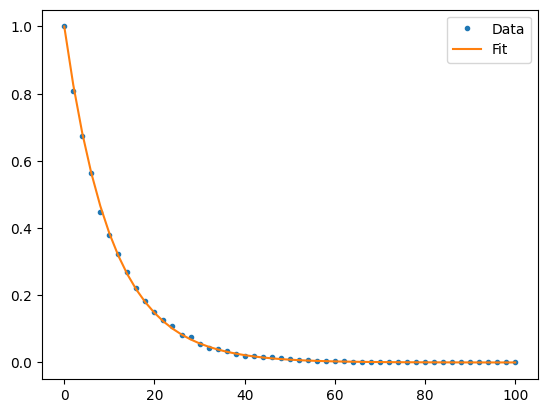

In [54]:
plt.plot(t_eval, sq.experimental.utils.expectation_value_to_prob_minus(expval_z), '.', label="Data")
plt.plot(t_eval, exponential_decay_model(t_eval, 1., optimized_param['T1']), label="Fit") # type: ignore
plt.legend()

In [55]:
optimized_param

{'T1': Array(10.45988849, dtype=float64)}